For a linear regression, $y_i = \hat{b}x_i+\hat{\alpha}$, the analysis for $\hat{\beta}$ is as follows: 

$$
\begin{align}
H_0 &: \beta = 0 && \textit{i.e., there no relationship between $x_i$ and $y_i$}\\
H_a &: \beta \neq 0 \\
& \\
     \textit{p value} &= 2*P(|T| \geq |t| | H_0) && \textit{calculate probability of data/t-statistic/estimator given the null is true}\\
     &= 2* \left[ 1 - F\left(\textit{residual degrees of freedom}, \left| \textit{t-statistic} \right|\right) \right] \\
     &=  2 * \left[ 1 - F_{rdf} \left(\left| \frac{\hat{\beta}-0}{SE \left(\hat{\beta}\right)}\right| \right) \right]  && since \: H_0: \: \hat{\beta} = 0\\ 
     &=  2 * \left[ 1 - F_{\textit{n-2}} \left(\frac{\left| \hat{\beta}\right|}{\frac{1}{n-2}\frac{\Sigma\epsilon_i^2}{\Sigma(x_i - \bar{x})^2}} \right) \right] && since \: \textit{rdf} = n-(k+1)\\ 
   \lim_{n \to \infty} \textit{p value}  &=   \lim_{n \to \infty} 2 * \left[ 1 - 
   \Phi_{\textit{n-2}} \left(\frac{\left| \hat{\beta}\right|}{\frac{1}{n-2}\frac{\Sigma\epsilon_i^2}{\Sigma(x_i - \bar{x})^2}} \right) \right] && since \: \textit{t-distribution converges to standard normal as } n \to \infty \\ 
&=  2 * \left[ 1 - 
   \lim_{n \to \infty} \Phi_{\textit{n-2}} \left(\frac{\left| \hat{\beta}\right|}{\frac{1}{n-2}\frac{\Sigma\epsilon_i^2}{\Sigma(x_i - \bar{x})^2}} \right) \right] \\
\end{align}
$$

$$
\begin{align}
\qquad &=
\begin{cases}
 2* \left[ 1- \Phi_{n-2}(0) \right] = 2*\frac{1}{2}= 1 && if \: H_0: \: \beta = 0 \: \textit{since then the numerator = 0}\\
 2* \left[ 1- \Phi_{n-2}(\infty) \right] = 2*0=0 && if \: H_a: \: \beta \neq 0 \: \textit{since then the numerator > 0, and as $n \to \infty$ the denominator } \to 0\\
\end{cases} 
\end{align}
$$

So as long as the null isn't precisely true (to an infinite number of decimal points) we can increase n to eventually find a sample size for which the null hypotheis will be rejected. In other words, we can find that there is a statistically significant relationship between $x_i$ and $y_i$ (but can't make any statment about the magnitude of the relationship: $\left| \hat{\beta} \right|)$. 

In [616]:
library(dplyr)
library(ggplot2)
library("emdbook")
library("gridExtra")

### Generate linear data & ols model

In [505]:
n <- 10000

x_mu <- 0
x_sd <- 10
df <- data.frame("x" = rnorm(n,x_mu,x_sd))

e_mu <- 0
e_sd <- 10
df$e <- rnorm(n, e_mu, e_sd)

### Look at mean of p values generated across different sample sizes

In [518]:
results <- data.frame("n" = numeric(),
                      "b_hat_mu" = numeric(),
                      "p_mu" = numeric(),
                      "beta" = character())

betas <- seq(from=0, to=.5, by=.1)
sample_sizes <- lseq(from=10, to=7000, length.out=100)
iterations <- seq(from=1, to=10)

for(b in betas) { #loop through different effect sizes
    df$y <- b*df$x + df$e
    for (n in sample_sizes){ #loop through sample sizes
        p_vals <- list()
        b_hats <- list()
        for (i in iterations){ #loop through runs to get aggregate mean
            sample <- df[sample(1:nrow(df), size = n, replace = TRUE), ]  
            model <- lm(sample$y~sample$x, x=TRUE, y=TRUE) 
            b_hat <- summary(model)$coefficients[2] #estimate
            b_hats <- append(b_hats, b_hat)
            p_val <- summary(model)$coefficients[2,4] #p-value of estimate
#            print(sprintf("b: %f, p_val: %f, n: %f", b_hat, p_val, n))
            p_vals <- append(p_vals, p_val)
        }
        results <- results %>% add_row(n=n,
                                       b_hat_mu=mean(unlist(b_hats)),
                                       p_mu=mean(unlist(p_vals)),
                                       beta=as.character(b))
    }
}

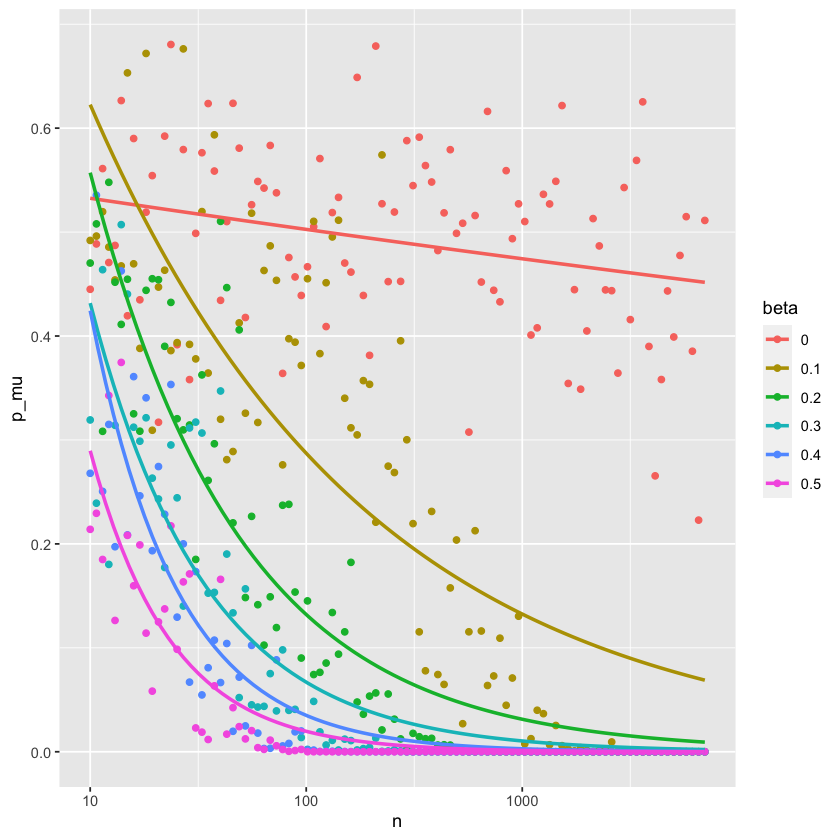

In [519]:
ggplot(data = results, aes(x=n, y=p_mu, group=beta)) + 
    geom_point(aes(col = beta)) + 
    geom_smooth(aes(col = beta), 
                method = "glm", 
                formula = "y ~ x", 
                se = FALSE, 
                method.args = list(family = gaussian(link = 'log'))) + 
    scale_x_continuous(trans="log10")

#I don't understand why beta=0 doesn't go to 1

# obs 1. the larger the effect the quicker (in terms of n) the p value drops to zero
# obs 2. as the sample size (n) increases the p value decreases (because the standard error decreases)

### Look at standard error as sample size increases

In [605]:
se_results <- data.frame("n" = numeric(),
                        "b_hat" = numeric(),
                        "beta" = character(),
                        "b_se" = numeric())

betas <- seq(from=0, to=.5, by=.25)
sample_sizes <- lseq(from=10, to=20000, length.out=100)
iterations <- seq(from=1, to=10)

for(b in betas) { #loop through different effect sizes
    df$y <- b*df$x + df$e
    for (n in sample_sizes){ #loop through sample sizes
        p_vals <- list()
        b_hats <- list()
        for (i in iterations){ #loop through runs to get aggregate mean
            sample <- df[sample(1:nrow(df), size = n, replace = TRUE), ]  
            model <- lm(sample$y~sample$x, x=TRUE, y=TRUE) 
            b_hat <- summary(model)$coefficients[2] #estimate
            b_se <- summary(model)$coefficients[2,2]
            se_results <- se_results %>% add_row(n=n,
                                           b_hat=b_hat,
                                           beta=as.character(b),
                                           b_se=b_se)        
        }
    }
}

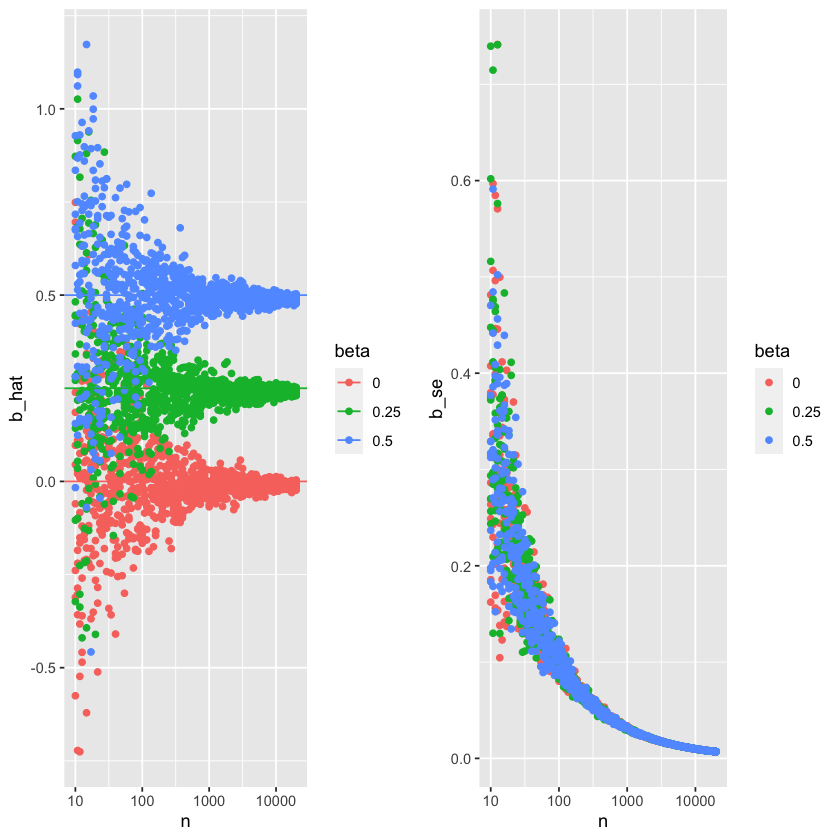

In [615]:
p1 <- ggplot(data = se_results) + 
    geom_point(aes(x=n, y=b_hat, group=beta, col=beta)) + 
    geom_hline(aes(yintercept = as.double(beta), color = factor(beta))) + 
    scale_x_continuous(trans="log10")

p2 <- ggplot(data = se_results) + 
    geom_point(aes(x=n, y=b_se, group=beta, col=beta)) + 
    scale_x_continuous(trans="log10")

grid.arrange(p1, p2, nrow=1)

# obs 1. as n increases the mean of the estimators (b_hat) converges towards the actual value (beta)
# obs 2. as n increases the standard error of the estimator (b_hat) converges to 0 

### Look at case $\beta = 0$

In [561]:
b0_results <- data.frame("n" = numeric(),
                        "b_hat" = numeric(),
                        "p" = numeric())

sample_sizes <- lseq(from=10, to=100000, length.out=500)
iterations <- seq(from=1, to=100)

beta <- 0
df$y <- beta*df$x + df$e
for (n in sample_sizes){ #loop through sample sizes
        for (i in iterations){ #loop through runs to get aggregate mean
            sample <- df[sample(1:nrow(df), size = n, replace = TRUE), ]  
            model <- lm(sample$y~sample$x, x=TRUE, y=TRUE) 
            b_hat <- summary(model)$coefficients[2] #estimate
            p_val <- summary(model)$coefficients[2,4] #p-value of estimate
            b0_results <- b0_results %>% add_row(n=n,
                                                b_hat=b_hat,
                                                p=p_val)        
        }

}

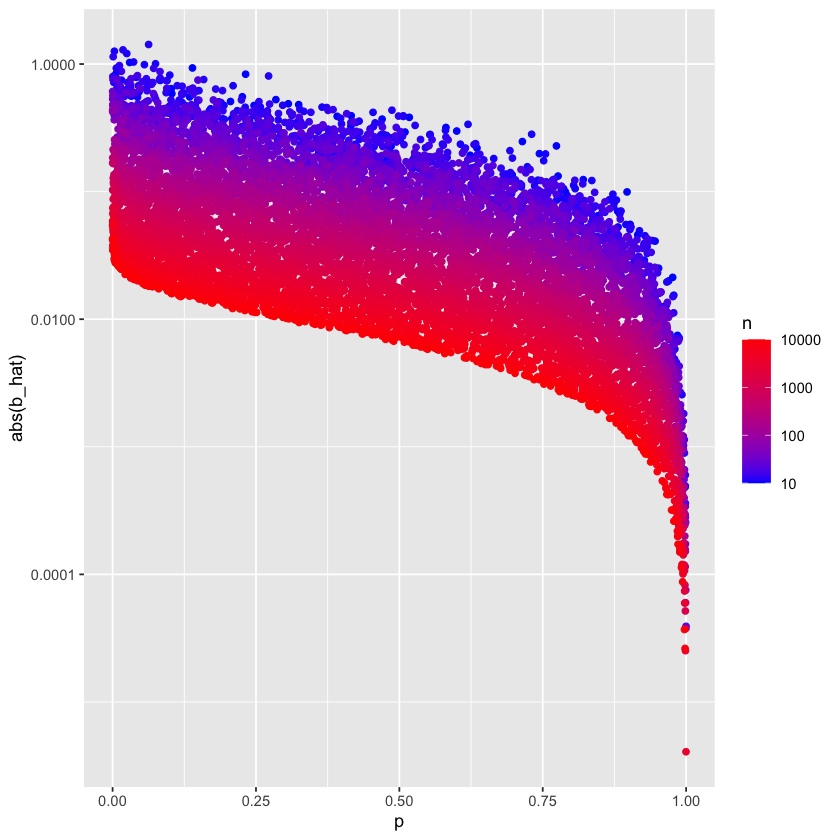

In [560]:
options(scipen=10000)
ggplot(data = b0_results, aes(x=p, y=abs(b_hat), group=n)) + 
    geom_point(aes(col = n)) + 
    scale_color_gradient(low="blue", high="red", trans="log10") +
    scale_y_continuous(trans="log10") 

# obs 1. as n grows |b_hat| gets smaller (closer to the true beta of zero)
# obs 2. as |b_hat| gets smaller, the p_val gets closer to 1

### Create basic model

In [514]:
beta <- 0
df$y <- beta*df$x + df$e
model <- lm(df$y~df$x, x=TRUE, y=TRUE)

### Manually calculate model-level key statistics

In [510]:
#sample variance
ssdy <- sum((df$y - mean(df$y))^2) #variance of y
degf <- n-1
svar <- ssdy/degf #sample variance - with Bessel's correction: n-1 (vs N) for an unbiased estimate
all.equal(svar, var(df$y)) #check

#residuals
estimates <- coef(model)
predicted_y <- estimates[2]*df$x + estimates[1]
df$r <- df$y - predicted_y #residual
all.equal(unname(model$residuals), df$r) #check

#residual standard error
rss <- sum(df$r**2) #residual sum of squares
rse <- sqrt(sum(rss)/(degf-1)) #residual standard error 
all.equal(rse, summary(model)$sigma)

#multiple R-squared
rsq <- 1 - (rss/ssdy) 
all.equal(rsq, summary(model)$r.squared)

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

### Manually calculate regressor-level key statistics

In [511]:
# (Null) H_0: beta_hat = 0
# (Alternative) H_a: beta_hat /= 0

#the estimate
beta_hat <- unname(model$coefficients["df$x"])

#estimate standard error
ssdx <- sum((df$x - mean(df$x))^2) #variance of x
rse <- sum(df$r^2)/(degf-1) 
beta_se <- sqrt(rse/ssdx)
all.equal(beta_se, summary(model)$coefficients[2,2])

#estimate t statistic
beta_t <- beta_hat/beta_se
all.equal(beta_t, summary(model)$coefficients[2,3])

#estimate (2-sided) p value
beta_p <- 2*min(1-(pt(q=beta_t, df=degf-1, lower.tail=FALSE)), 
                 pt(q=beta_t, df=degf-1, lower.tail=FALSE)) #right side
all.equal(beta_p, summary(model)$coefficients[2,4])

[1] TRUE

[1] TRUE

[1] TRUE